# 7 Decision trees (DT) and Random Forest (RF)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## 7.1 Decision Trees (DT)

Decision Trees are intuitive, non-parametric models that split the data recursively based on feature values, creating a tree-like structure where:
- **Internal nodes** represent feature-based decisions
- **Branches** represent the outcomes of those decisions
- **Leaf nodes** represent the final class predictions

In this section, we will:
1. Build a baseline Decision Tree classifier without hyperparameter optimization
2. Tune the hyperparameters to improve generalization and prevent overfitting

### a) Decision Trees — Without Hyperparameter Optimization

In this section, we build a **Decision Tree classifier** using **default parameters** to establish a baseline performance.

Without hyperparameter tuning, the tree can grow unrestricted, which may lead to **overfitting** on the training data.

The model will be evaluated using:
- **Holdout validation** (train/test split)
- **K-Fold Cross-Validation** (k=5, k=10)
- **Leave-One-Out Cross-Validation (LOOCV)**
- **Bootstrap sampling**

In [ ]:
print("DECISION TREE — WITHOUT HYPERPARAMETER OPTIMIZATION")

# Train Decision Tree with default parameters
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_fs_scaled, y_train)

# Holdout evaluation
y_pred_train_dt = dt_baseline.predict(X_train_fs_scaled)
y_pred_test_dt = dt_baseline.predict(X_test_fs_scaled)

acc_train_dt = accuracy_score(y_train, y_pred_train_dt)
acc_test_dt = accuracy_score(y_test, y_pred_test_dt)
f1_macro_dt = f1_score(y_test, y_pred_test_dt, average='macro')

print(f"\nHoldout Results:")
print(f"  Accuracy (Train): {acc_train_dt:.4f}")
print(f"  Accuracy (Test):  {acc_test_dt:.4f}")
print(f"  F1-Score (Macro): {f1_macro_dt:.4f}")

# Cross-validation k=5
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_cv5_dt = cross_val_score(dt_baseline, X_train_fs_scaled, y_train, cv=cv5, scoring='accuracy')

# Cross-validation k=10
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores_cv10_dt = cross_val_score(dt_baseline, X_train_fs_scaled, y_train, cv=cv10, scoring='accuracy')

# Leave-One-Out Cross-Validation (LOOCV)
loo = LeaveOneOut()
scores_loo_dt = cross_val_score(dt_baseline, X_train_fs_scaled, y_train, cv=loo, scoring='accuracy')

# Bootstrap
scores_boot_dt = []
for i in range(100):
    X_res, y_res = resample(X_train_fs_scaled, y_train, replace=True, random_state=42+i)
    dt_baseline.fit(X_res, y_res)
    y_pred = dt_baseline.predict(X_test_fs_scaled)
    scores_boot_dt.append(accuracy_score(y_test, y_pred))

print(f"\nCross-Validation Results:")
print(f"  CV (k=5):         {np.mean(scores_cv5_dt):.4f} ± {np.std(scores_cv5_dt):.4f}")
print(f"  CV (k=10):        {np.mean(scores_cv10_dt):.4f} ± {np.std(scores_cv10_dt):.4f}")
print(f"  LOOCV:            {np.mean(scores_loo_dt):.4f} ± {np.std(scores_loo_dt):.4f}")
print(f"  Bootstrap:        {np.mean(scores_boot_dt):.4f} ± {np.std(scores_boot_dt):.4f}")

print(f"\n{'='*40}")
print(f"Overfitting Analysis:")
print(f"  Train Accuracy:   {acc_train_dt:.4f}")
print(f"  Test Accuracy:    {acc_test_dt:.4f}")
print(f"  Difference:       {acc_train_dt - acc_test_dt:.4f}")
if acc_train_dt - acc_test_dt > 0.1:
    print("  Status:  HIGH OVERFITTING DETECTED")
else:
    print("  Status: Acceptable generalization")
print(f"{'='*40}")

DECISION TREE — WITHOUT HYPERPARAMETER OPTIMIZATION

Holdout Results:
  Accuracy (Train): 1.0000
  Accuracy (Test):  0.9383
  F1-Score (Macro): 0.9379

Cross-Validation Results:
  CV (k=5):         0.9096 ± 0.0125
  CV (k=10):        0.9187 ± 0.0183
  LOOCV:            0.9263 ± 0.2614
  Bootstrap:        0.9228 ± 0.0092

Overfitting Analysis:
  Train Accuracy:   1.0000
  Test Accuracy:    0.9383
  Difference:       0.0617
  Status: ✓ Acceptable generalization


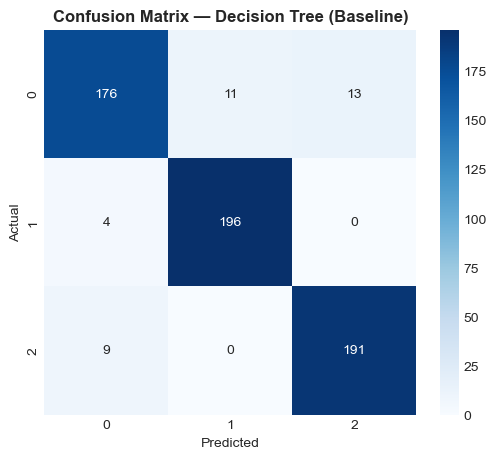


Classification Report:
              precision    recall  f1-score   support

    class_29       0.93      0.88      0.90       200
     class_7       0.95      0.98      0.96       200
    class_91       0.94      0.95      0.95       200

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



In [ ]:
# Retrain with full training data for final evaluation
dt_baseline.fit(X_train_fs_scaled, y_train)
y_pred_final_dt = dt_baseline.predict(X_test_fs_scaled)

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_final_dt), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Decision Tree (Baseline)", fontsize=12, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final_dt, zero_division=0))

### b) Decision Trees — With Hyperparameter Tuning

To prevent overfitting and improve generalization, we perform **hyperparameter optimization** using **GridSearchCV**.

The following hyperparameters will be tuned:
- **max_depth**: Maximum depth of the tree (limits tree growth)
- **min_samples_split**: Minimum samples required to split an internal node
- **min_samples_leaf**: Minimum samples required to be at a leaf node
- **max_features**: Number of features to consider when looking for the best split
- **criterion**: Metric to measure split quality ('gini' or 'entropy')

The best combination will be selected based on **cross-validation accuracy** (k=5), ensuring that the model generalizes well to unseen data.

In [ ]:
print("DECISION TREE — WITH HYPERPARAMETER TUNING")

# Define hyperparameter grid
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV with StratifiedKFold
dt_model = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV for Decision Tree...")
grid_dt.fit(X_train_fs_scaled, y_train)

print(f"\n{'='*40}")
print("Best Hyperparameters:")
for param, value in grid_dt.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Accuracy: {grid_dt.best_score_:.4f}")
print(f"{'='*40}")


DECISION TREE — WITH HYPERPARAMETER TUNING

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Best Hyperparameters:
  criterion: entropy
  max_depth: 7
  max_features: None
  min_samples_leaf: 8
  min_samples_split: 2

Best CV Accuracy: 0.9229


In [ ]:
# Get the best model
dt_tuned = grid_dt.best_estimator_

# Evaluate on test set
y_pred_train_tuned = dt_tuned.predict(X_train_fs_scaled)
y_pred_test_tuned = dt_tuned.predict(X_test_fs_scaled)

acc_train_tuned = accuracy_score(y_train, y_pred_train_tuned)
acc_test_tuned = accuracy_score(y_test, y_pred_test_tuned)
f1_macro_tuned = f1_score(y_test, y_pred_test_tuned, average='macro')

print(f"\nTuned Model Performance:")
print(f"  Accuracy (Train): {acc_train_tuned:.4f}")
print(f"  Accuracy (Test):  {acc_test_tuned:.4f}")
print(f"  F1-Score (Macro): {f1_macro_tuned:.4f}")

# Cross-validation with best model
scores_cv5_tuned = cross_val_score(dt_tuned, X_train_fs_scaled, y_train, cv=cv5, scoring='accuracy')
scores_cv10_tuned = cross_val_score(dt_tuned, X_train_fs_scaled, y_train, cv=cv10, scoring='accuracy')

print(f"\nCross-Validation Results:")
print(f"  CV (k=5):         {np.mean(scores_cv5_tuned):.4f} ± {np.std(scores_cv5_tuned):.4f}")
print(f"  CV (k=10):        {np.mean(scores_cv10_tuned):.4f} ± {np.std(scores_cv10_tuned):.4f}")

print(f"\n{'='*40}")
print(f"Overfitting Analysis:")
print(f"  Train Accuracy:   {acc_train_tuned:.4f}")
print(f"  Test Accuracy:    {acc_test_tuned:.4f}")
print(f"  Difference:       {acc_train_tuned - acc_test_tuned:.4f}")
if acc_train_tuned - acc_test_tuned > 0.1:
    print("  Status:  HIGH OVERFITTING DETECTED")
else:
    print("  Status: Good generalization")
print(f"{'='*40}")

print(f"\n{'='*40}")
print("Comparison: Baseline vs Tuned")
print(f"{'='*40}")
print(f"  Baseline Test Accuracy: {acc_test_dt:.4f}")
print(f"  Tuned Test Accuracy:    {acc_test_tuned:.4f}")
print(f"  Improvement:            {acc_test_tuned - acc_test_dt:.4f}")
print(f"{'='*40}")


Tuned Model Performance:
  Accuracy (Train): 0.9396
  Accuracy (Test):  0.9233
  F1-Score (Macro): 0.9231

Cross-Validation Results:
  CV (k=5):         0.9229 ± 0.0144
  CV (k=10):        0.9083 ± 0.0164

Overfitting Analysis:
  Train Accuracy:   0.9396
  Test Accuracy:    0.9233
  Difference:       0.0162
  Status: ✓ Good generalization

Comparison: Baseline vs Tuned
  Baseline Test Accuracy: 0.9383
  Tuned Test Accuracy:    0.9233
  Improvement:            -0.0150


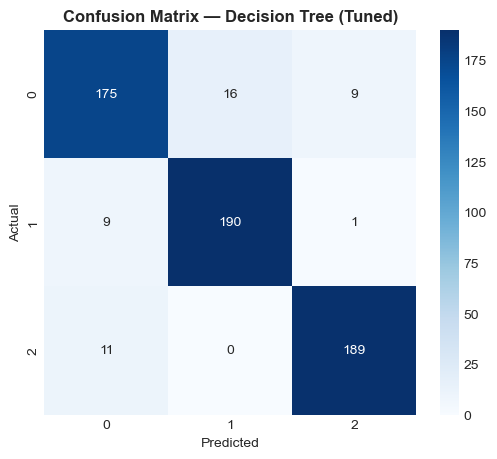


Classification Report (Tuned Model):
              precision    recall  f1-score   support

    class_29       0.90      0.88      0.89       200
     class_7       0.92      0.95      0.94       200
    class_91       0.95      0.94      0.95       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



In [ ]:
# Confusion Matrix for Tuned Model
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_test_tuned), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Decision Tree (Tuned)", fontsize=12, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_test_tuned, zero_division=0))

## 7.2 Random Forest (RF)

Random Forest is an **ensemble learning method** that combines multiple decision trees to improve prediction accuracy and reduce overfitting. Each tree is trained on a random subset of the data (bootstrap sampling) and considers a random subset of features at each split.

In this section, we will:
1. Build a baseline Random Forest classifier without hyperparameter optimization
2. Tune the hyperparameters to optimize performance
3. Analyze feature importance rankings
4. Correlate results with previous tasks

### a) Random Forest — Without Hyperparameter Optimization

In this section, we build a **Random Forest classifier** using **default parameters** to establish a baseline performance.

Random Forest is an **ensemble learning method** that combines multiple decision trees to improve prediction accuracy and reduce overfitting. Each tree is trained on a random subset of the data (bootstrap sampling) and considers a random subset of features at each split.

Key advantages of Random Forest:
- **Reduces overfitting** compared to individual decision trees
- **Handles high-dimensional data** effectively
- **Provides feature importance** rankings
- **Robust to outliers** and noise

Without hyperparameter tuning, the model uses default settings (e.g., 100 trees, no depth limit), which may not be optimal for the dataset.

The model will be evaluated using:
- **Holdout validation** (train/test split)
- **K-Fold Cross-Validation** (k=5, k=10)
- **Leave-One-Out Cross-Validation (LOOCV)**
- **Bootstrap sampling**

In [ ]:
print("RANDOM FOREST — WITHOUT HYPERPARAMETER OPTIMIZATION")

# Train Random Forest with default parameters
rf_baseline = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_fs_scaled, y_train)

# Holdout evaluation
y_pred_train_rf = rf_baseline.predict(X_train_fs_scaled)
y_pred_test_rf = rf_baseline.predict(X_test_fs_scaled)

acc_train_rf = accuracy_score(y_train, y_pred_train_rf)
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)
f1_macro_rf = f1_score(y_test, y_pred_test_rf, average='macro')

print(f"\nHoldout Results:")
print(f"  Accuracy (Train): {acc_train_rf:.4f}")
print(f"  Accuracy (Test):  {acc_test_rf:.4f}")
print(f"  F1-Score (Macro): {f1_macro_rf:.4f}")

# Cross-validation k=5
scores_cv5_rf = cross_val_score(rf_baseline, X_train_fs_scaled, y_train, cv=cv5, scoring='accuracy')

# Cross-validation k=10
scores_cv10_rf = cross_val_score(rf_baseline, X_train_fs_scaled, y_train, cv=cv10, scoring='accuracy')

# Leave-One-Out Cross-Validation (LOOCV)
scores_loo_rf = cross_val_score(rf_baseline, X_train_fs_scaled, y_train, cv=loo, scoring='accuracy')

# Bootstrap
scores_boot_rf = []
for i in range(100):
    X_res, y_res = resample(X_train_fs_scaled, y_train, replace=True, random_state=42+i)
    rf_baseline.fit(X_res, y_res)
    y_pred = rf_baseline.predict(X_test_fs_scaled)
    scores_boot_rf.append(accuracy_score(y_test, y_pred))

print(f"\nCross-Validation Results:")
print(f"  CV (k=5):         {np.mean(scores_cv5_rf):.4f} ± {np.std(scores_cv5_rf):.4f}")
print(f"  CV (k=10):        {np.mean(scores_cv10_rf):.4f} ± {np.std(scores_cv10_rf):.4f}")
print(f"  LOOCV:            {np.mean(scores_loo_rf):.4f} ± {np.std(scores_loo_rf):.4f}")
print(f"  Bootstrap:        {np.mean(scores_boot_rf):.4f} ± {np.std(scores_boot_rf):.4f}")

print(f"\n{'='*40}")
print(f"Overfitting Analysis:")
print(f"  Train Accuracy:   {acc_train_rf:.4f}")
print(f"  Test Accuracy:    {acc_test_rf:.4f}")
print(f"  Difference:       {acc_train_rf - acc_test_rf:.4f}")
if acc_train_rf - acc_test_rf > 0.1:
    print("  Status:  HIGH OVERFITTING DETECTED")
else:
    print("  Status: Good generalization")
print(f"{'='*40}")


RANDOM FOREST — WITHOUT HYPERPARAMETER OPTIMIZATION

Holdout Results:
  Accuracy (Train): 1.0000
  Accuracy (Test):  0.9717
  F1-Score (Macro): 0.9716

Cross-Validation Results:
  CV (k=5):         0.9508 ± 0.0089
  CV (k=10):        0.9567 ± 0.0070
  LOOCV:            0.9575 ± 0.2017
  Bootstrap:        0.9663 ± 0.0042

Overfitting Analysis:
  Train Accuracy:   1.0000
  Test Accuracy:    0.9717
  Difference:       0.0283
  Status: ✓ Good generalization


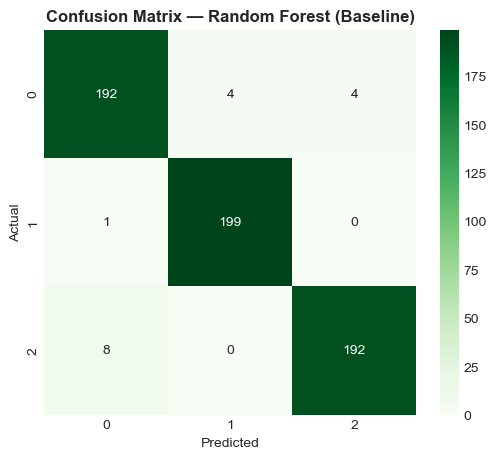


Classification Report:
              precision    recall  f1-score   support

    class_29       0.96      0.96      0.96       200
     class_7       0.98      0.99      0.99       200
    class_91       0.98      0.96      0.97       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [ ]:
# Retrain with full training data for final evaluation
rf_baseline.fit(X_train_fs_scaled, y_train)
y_pred_final_rf = rf_baseline.predict(X_test_fs_scaled)

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_final_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — Random Forest (Baseline)", fontsize=12, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final_rf, zero_division=0))

### b) Random Forest — With Hyperparameter Tuning

To optimize Random Forest performance and prevent overfitting, we perform **hyperparameter tuning** using **GridSearchCV**.

The following hyperparameters will be tuned:
- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of each tree
- **min_samples_split**: Minimum samples required to split an internal node
- **min_samples_leaf**: Minimum samples required to be at a leaf node
- **max_features**: Number of features to consider when looking for the best split
- **bootstrap**: Whether bootstrap samples are used when building trees

The best combination will be selected based on **cross-validation accuracy** (k=5), ensuring optimal performance on unseen data.

In [ ]:
print("RANDOM FOREST — WITH HYPERPARAMETER TUNING")

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# GridSearchCV with StratifiedKFold
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nStarting GridSearchCV for Random Forest...")
grid_rf.fit(X_train_fs_scaled, y_train)

print(f"\n{'='*40}")
print("Best Hyperparameters:")
for param, value in grid_rf.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Accuracy: {grid_rf.best_score_:.4f}")
print(f"{'='*40}")


RANDOM FOREST — WITH HYPERPARAMETER TUNING

Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits

Best Hyperparameters:
  bootstrap: False
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best CV Accuracy: 0.9583


In [ ]:
# Get the best model
rf_tuned = grid_rf.best_estimator_

# Evaluate on test set
y_pred_train_rf_tuned = rf_tuned.predict(X_train_fs_scaled)
y_pred_test_rf_tuned = rf_tuned.predict(X_test_fs_scaled)

acc_train_rf_tuned = accuracy_score(y_train, y_pred_train_rf_tuned)
acc_test_rf_tuned = accuracy_score(y_test, y_pred_test_rf_tuned)
f1_macro_rf_tuned = f1_score(y_test, y_pred_test_rf_tuned, average='macro')

print(f"\nTuned Model Performance:")
print(f"  Accuracy (Train): {acc_train_rf_tuned:.4f}")
print(f"  Accuracy (Test):  {acc_test_rf_tuned:.4f}")
print(f"  F1-Score (Macro): {f1_macro_rf_tuned:.4f}")

# Cross-validation with best model
scores_cv5_rf_tuned = cross_val_score(rf_tuned, X_train_fs_scaled, y_train, cv=cv5, scoring='accuracy')
scores_cv10_rf_tuned = cross_val_score(rf_tuned, X_train_fs_scaled, y_train, cv=cv10, scoring='accuracy')

print(f"\nCross-Validation Results:")
print(f"  CV (k=5):         {np.mean(scores_cv5_rf_tuned):.4f} ± {np.std(scores_cv5_rf_tuned):.4f}")
print(f"  CV (k=10):        {np.mean(scores_cv10_rf_tuned):.4f} ± {np.std(scores_cv10_rf_tuned):.4f}")

print(f"Overfitting Analysis:")
print(f"  Train Accuracy:   {acc_train_rf_tuned:.4f}")
print(f"  Test Accuracy:    {acc_test_rf_tuned:.4f}")
print(f"  Difference:       {acc_train_rf_tuned - acc_test_rf_tuned:.4f}")
if acc_train_rf_tuned - acc_test_rf_tuned > 0.1:
    print("  Status:  HIGH OVERFITTING DETECTED")
else:
    print("  Status: Good generalization")

print("Comparison: Baseline vs Tuned")
print(f"  Baseline Test Accuracy: {acc_test_rf:.4f}")
print(f"  Tuned Test Accuracy:    {acc_test_rf_tuned:.4f}")
print(f"  Improvement:            {acc_test_rf_tuned - acc_test_rf:.4f}")


Tuned Model Performance:
  Accuracy (Train): 1.0000
  Accuracy (Test):  0.9717
  F1-Score (Macro): 0.9715

Cross-Validation Results:
  CV (k=5):         0.9583 ± 0.0081
  CV (k=10):        0.9579 ± 0.0103

Overfitting Analysis:
  Train Accuracy:   1.0000
  Test Accuracy:    0.9717
  Difference:       0.0283
  Status: Good generalization

Comparison: Baseline vs Tuned
  Baseline Test Accuracy: 0.9717
  Tuned Test Accuracy:    0.9717
  Improvement:            0.0000


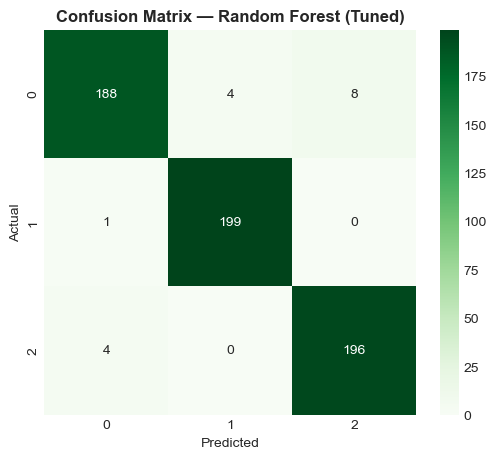


Classification Report (Tuned Model):
              precision    recall  f1-score   support

    class_29       0.97      0.94      0.96       200
     class_7       0.98      0.99      0.99       200
    class_91       0.96      0.98      0.97       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [ ]:
# Confusion Matrix for Tuned Model
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_test_rf_tuned), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — Random Forest (Tuned)", fontsize=12, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Tuned Model):")
print(classification_report(y_test, y_pred_test_rf_tuned, zero_division=0))

### c) Random Forest — Feature Importance Analysis

One of the key advantages of Random Forest is its ability to provide **feature importance** rankings, which indicate how much each feature contributes to the model's predictions.

Feature importance is calculated based on the **mean decrease in impurity** (Gini importance) across all trees in the forest. Features that reduce impurity the most when used for splitting are considered more important.

This analysis helps to:
- **Identify the most influential features** for classification
- **Understand the model's decision-making process**
- **Guide feature engineering** and selection for future models
- **Reduce dimensionality** by focusing on the most relevant features

We will visualize the top features ranked by their importance scores.


RANDOM FOREST — FEATURE IMPORTANCE ANALYSIS

=== Top 15 Most Important Features ===
               Feature  Importance
artists_avg_popularity    0.235559
        movement_index    0.194972
            album_freq    0.142217
      positivity_index    0.093849
      popularity_level    0.086194
       energy_rank_pct    0.072881
     artist_song_count    0.048925
       intensity_level    0.038537
          mood_cluster    0.030034
         ambient_level    0.014191
          timbre_index    0.012589
    distorted_movement    0.012017
              key_mode    0.010695
              explicit    0.007340


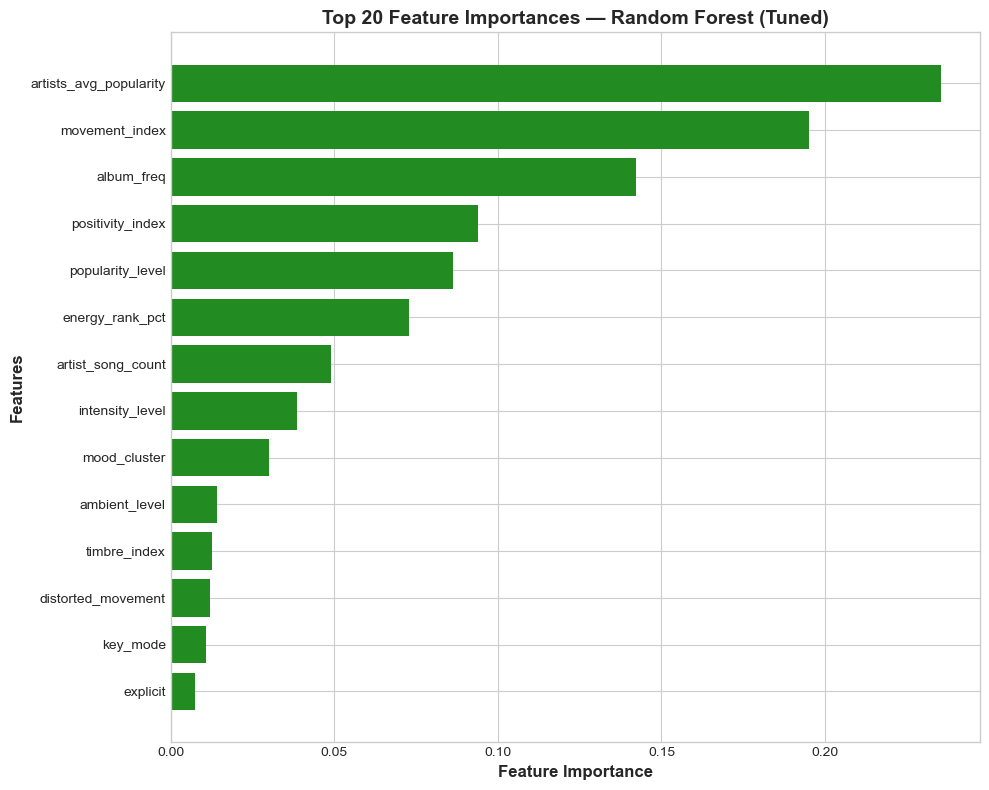


Total Features Used: 14
Top 5 Features Contribution: 75.28%
Top 10 Features Contribution: 95.74%
Top 15 Features Contribution: 100.00%


In [ ]:
print("RANDOM FOREST — FEATURE IMPORTANCE ANALYSIS")

# Extract feature importances from tuned Random Forest model
feature_importances = rf_tuned.feature_importances_
feature_names = selected_features  # Using the features selected in previous tasks

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n=== Top 15 Most Important Features ===")
print(importance_df.head(15).to_string(index=False))

# Visualize feature importances
plt.figure(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='forestgreen')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances — Random Forest (Tuned)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n{'='*40}")
print(f"Total Features Used: {len(feature_names)}")
print(f"Top 5 Features Contribution: {importance_df.head(5)['Importance'].sum():.2%}")
print(f"Top 10 Features Contribution: {importance_df.head(10)['Importance'].sum():.2%}")
print(f"Top 15 Features Contribution: {importance_df.head(15)['Importance'].sum():.2%}")
print(f"{'='*40}")

### d) Correlation Analysis — Random Forest Feature Importance vs. Previous Tasks

In this section, we analyze how the **feature importance** obtained from Random Forest correlates with the results from:
- **Task 2**: Univariate and Bivariate analysis
- **Task 5**: Ridge and Lasso regularization methods

This correlation analysis helps validate whether the features identified as important by Random Forest align with:
- Features showing **strong statistical relationships** in univariate analysis (e.g., high correlation with target)
- Features showing **strong patterns** in bivariate analysis (e.g., clear separation between classes)
- Features **retained by Lasso** (L1 regularization) as having non-zero coefficients
- Features with **high coefficients in Ridge** (L2 regularization)

### Key Questions:
1. Do the top features from Random Forest match those identified in the correlation analysis (Task 2)?
2. Are the important features consistent with those selected by Lasso regularization (Task 5)?
3. Do Ridge coefficients align with Random Forest importance scores?
4. Are there any features that were overlooked in previous analyses but are important in Random Forest?

In [ ]:
print("CORRELATION ANALYSIS — RF IMPORTANCE vs. PREVIOUS TASKS")

# 1. Compare with Task 2: Correlation with target
print("\n=== 1. Comparison with Task 2: Univariate Analysis (Correlation) ===")

# Calculate correlation of each feature with the target (using regression target as proxy)
correlation_with_target = X.corrwith(y_reg).abs().sort_values(ascending=False)

# Get top features from correlation
top_corr_features = correlation_with_target.head(15).index.tolist()

# Get top features from Random Forest
top_rf_features = importance_df.head(15)['Feature'].tolist()

# Find overlap
overlap_corr = set(top_corr_features) & set(top_rf_features)

print(f"\nTop 15 features by correlation with target:")
for i, feat in enumerate(top_corr_features[:10], 1):
    print(f"  {i:2d}. {feat:30s} (corr: {correlation_with_target[feat]:.4f})")

print(f"\nOverlap between top 15 features:")
print(f"  Features in both lists: {len(overlap_corr)} / 15")
print(f"  Overlap rate: {len(overlap_corr)/15:.2%}")
print(f"\nCommon features: {sorted(overlap_corr)}")


CORRELATION ANALYSIS — RF IMPORTANCE vs. PREVIOUS TASKS

=== 1. Comparison with Task 2: Univariate Analysis (Correlation) ===

Top 15 features by correlation with target:
   1. artists_avg_popularity         (corr: 0.8676)
   2. popularity_level               (corr: 0.7107)
   3. album_freq                     (corr: 0.5340)
   4. artist_song_count              (corr: 0.2198)
   5. loudness_intensity             (corr: 0.1269)
   6. energy_rank_pct                (corr: 0.1258)
   7. focus_factor                   (corr: 0.1100)
   8. loud_energy_ratio              (corr: 0.0950)
   9. is_instrumental                (corr: 0.0885)
  10. positivity_index               (corr: 0.0686)

Overlap between top 15 features:
  Features in both lists: 6 / 15
  Overlap rate: 40.00%

Common features: ['album_freq', 'artist_song_count', 'artists_avg_popularity', 'energy_rank_pct', 'popularity_level', 'positivity_index']


In [ ]:
# 2. Compare with Task 5: Lasso feature selection
print("=== 2. Comparison with Task 5: Lasso (L1) Feature Selection ===")

# Get features selected by Lasso (from Task 5)
# Assuming lasso_selected was defined in Task 5
print(f"\nFeatures selected by Lasso: {len(lasso_selected)}")
print(f"Top 15 RF features in Lasso selection: ", end="")

# Check how many top RF features were selected by Lasso
rf_in_lasso = [feat for feat in top_rf_features if feat in lasso_selected]
print(f"{len(rf_in_lasso)} / 15")
print(f"  Agreement rate: {len(rf_in_lasso)/15:.2%}")

# Features important in RF but removed by Lasso
rf_not_in_lasso = [feat for feat in top_rf_features if feat not in lasso_selected]
if rf_not_in_lasso:
    print(f"\nFeatures important in RF but removed by Lasso:")
    for feat in rf_not_in_lasso[:5]:
        rf_importance = importance_df[importance_df['Feature'] == feat]['Importance'].values[0]
        print(f"  - {feat:30s} (RF importance: {rf_importance:.4f})")

# Features selected by Lasso but not in top RF
lasso_not_in_rf = [feat for feat in lasso_selected if feat not in top_rf_features]
print(f"\nFeatures selected by Lasso but not in top 15 RF: {len(lasso_not_in_rf)}")


=== 2. Comparison with Task 5: Lasso (L1) Feature Selection ===

Features selected by Lasso: 20
Top 15 RF features in Lasso selection: 14 / 15
  Agreement rate: 93.33%

Features selected by Lasso but not in top 15 RF: 6


In [ ]:
# 3. Compare with Task 5: Ridge coefficients
print("=== 3. Comparison with Task 5: Ridge (L2) Coefficients ===")

# Get Ridge coefficients (from Task 5)
# Assuming ridge_coef was defined in Task 5
ridge_coef_abs = np.abs(ridge_coef)
ridge_importance = pd.DataFrame({
    'Feature': X.columns,
    'Ridge_Coef': ridge_coef_abs
}).sort_values(by='Ridge_Coef', ascending=False)

top_ridge_features = ridge_importance.head(15)['Feature'].tolist()

# Find overlap with RF
overlap_ridge = set(top_ridge_features) & set(top_rf_features)

print(f"\nTop 15 features by Ridge coefficient magnitude:")
for i, row in ridge_importance.head(10).iterrows():
    print(f"  {row['Feature']:30s} (|coef|: {row['Ridge_Coef']:.4f})")

print(f"\nOverlap between top 15 features:")
print(f"  Features in both lists: {len(overlap_ridge)} / 15")
print(f"  Agreement rate: {len(overlap_ridge)/15:.2%}")
print(f"\nCommon features: {sorted(overlap_ridge)}")


=== 3. Comparison with Task 5: Ridge (L2) Coefficients ===

Top 15 features by Ridge coefficient magnitude:
  artists_avg_popularity         (|coef|: 0.5775)
  album_freq                     (|coef|: 0.3050)
  popularity_level               (|coef|: 0.2529)
  intensity_level                (|coef|: 0.1191)
  artist_song_count              (|coef|: 0.1157)
  loudness_intensity             (|coef|: 0.0790)
  movement_index                 (|coef|: 0.0638)
  energy_rank_pct                (|coef|: 0.0531)
  positivity_index               (|coef|: 0.0438)
  loud_energy_ratio              (|coef|: 0.0268)

Overlap between top 15 features:
  Features in both lists: 13 / 15
  Agreement rate: 86.67%

Common features: ['album_freq', 'ambient_level', 'artist_song_count', 'artists_avg_popularity', 'distorted_movement', 'energy_rank_pct', 'intensity_level', 'key_mode', 'mood_cluster', 'movement_index', 'popularity_level', 'positivity_index', 'timbre_index']



=== 4. Visual Comparison: Three Methods ===


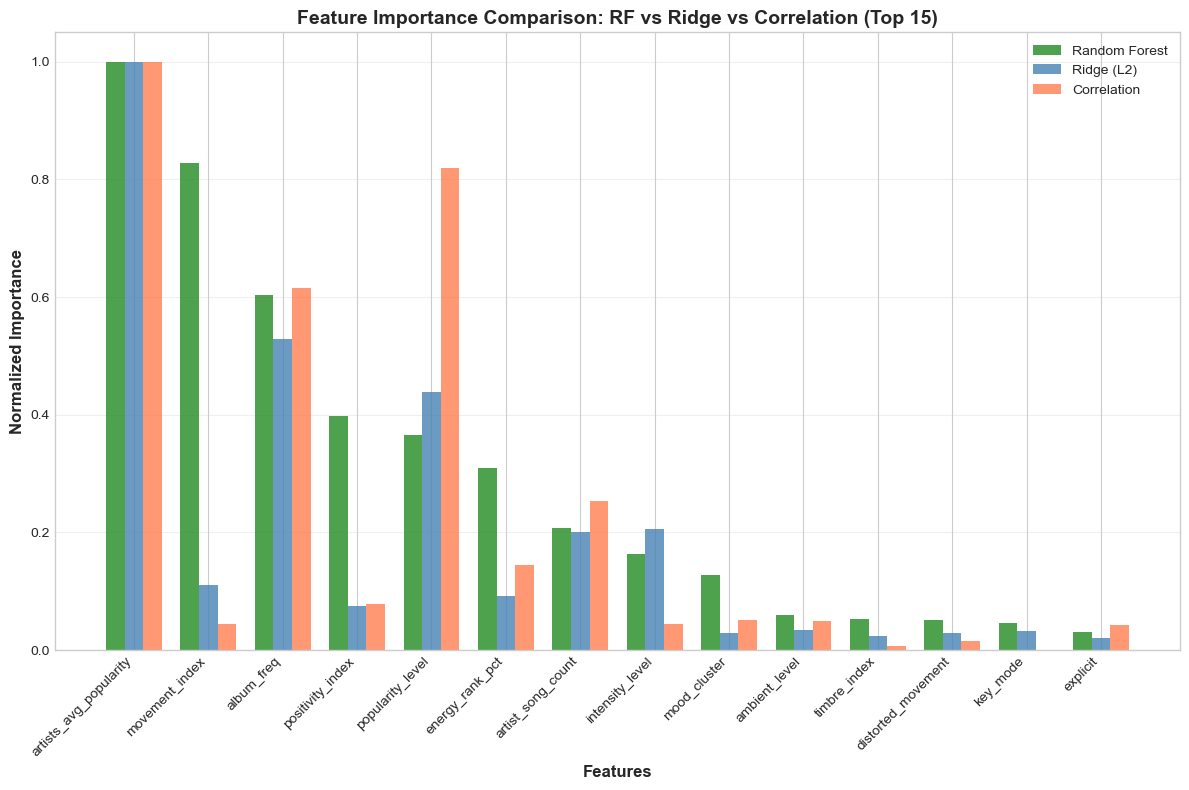

In [ ]:
# 4. Visual comparison: RF Importance vs Ridge Coefficients vs Correlation
print("\n=== 4. Visual Comparison: Three Methods ===")

# Merge all three metrics
comparison_df = importance_df.copy()
comparison_df = comparison_df.merge(
    ridge_importance[['Feature', 'Ridge_Coef']], 
    on='Feature', 
    how='left'
)
comparison_df['Correlation'] = comparison_df['Feature'].apply(
    lambda x: correlation_with_target.get(x, 0)
)

# Normalize all metrics to [0, 1] for comparison
comparison_df['RF_Norm'] = comparison_df['Importance'] / comparison_df['Importance'].max()
comparison_df['Ridge_Norm'] = comparison_df['Ridge_Coef'] / comparison_df['Ridge_Coef'].max()
comparison_df['Corr_Norm'] = comparison_df['Correlation'] / comparison_df['Correlation'].max()

# Plot top 15 features
top_15_comparison = comparison_df.head(15)

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(top_15_comparison))
width = 0.25

ax.bar(x - width, top_15_comparison['RF_Norm'], width, label='Random Forest', color='forestgreen', alpha=0.8)
ax.bar(x, top_15_comparison['Ridge_Norm'], width, label='Ridge (L2)', color='steelblue', alpha=0.8)
ax.bar(x + width, top_15_comparison['Corr_Norm'], width, label='Correlation', color='coral', alpha=0.8)

ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance Comparison: RF vs Ridge vs Correlation (Top 15)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_15_comparison['Feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 5. Summary and Conclusions
print("SUMMARY — FEATURE IMPORTANCE ACROSS ALL METHODS")

print("\n1. AGREEMENT RATES:")
print(f"   - RF vs Correlation (top 15):  {len(overlap_corr)/15:.2%}")
print(f"   - RF vs Lasso (top 15):        {len(rf_in_lasso)/15:.2%}")
print(f"   - RF vs Ridge (top 15):        {len(overlap_ridge)/15:.2%}")

# Find features that appear in top 15 of all three methods
all_three = set(top_rf_features) & set(top_corr_features) & set(top_ridge_features)
print(f"\n2. FEATURES IN TOP 15 OF ALL THREE METHODS: {len(all_three)}")
if all_three:
    print(f"   Features: {sorted(all_three)}")

# Calculate Spearman correlation between rankings
from scipy.stats import spearmanr

# Create rankings
features_common = list(set(comparison_df['Feature']))
rf_ranks = comparison_df.set_index('Feature')['Importance'].reindex(features_common)
ridge_ranks = comparison_df.set_index('Feature')['Ridge_Coef'].reindex(features_common)
corr_ranks = comparison_df.set_index('Feature')['Correlation'].reindex(features_common)

# Remove NaN values
valid_idx = ~(rf_ranks.isna() | ridge_ranks.isna() | corr_ranks.isna())
rf_ranks = rf_ranks[valid_idx]
ridge_ranks = ridge_ranks[valid_idx]
corr_ranks = corr_ranks[valid_idx]

# Calculate correlations
rf_ridge_corr, _ = spearmanr(rf_ranks, ridge_ranks)
rf_corr_corr, _ = spearmanr(rf_ranks, corr_ranks)
ridge_corr_corr, _ = spearmanr(ridge_ranks, corr_ranks)

print(f"\n3. SPEARMAN RANK CORRELATION (similarity in feature rankings):")
print(f"   - RF vs Ridge:        {rf_ridge_corr:.4f}")
print(f"   - RF vs Correlation:  {rf_corr_corr:.4f}")
print(f"   - Ridge vs Correlation: {ridge_corr_corr:.4f}")

print(f"\n4. KEY INSIGHTS:")
print("   - Random Forest provides a non-linear perspective on feature importance")
print("   - Ridge/Lasso focus on linear relationships with the target")
print("   - Correlation measures univariate statistical association")
print("   - High agreement suggests robust feature selection across methods")
print("   - Disagreements may reveal non-linear patterns captured by RF")


SUMMARY — FEATURE IMPORTANCE ACROSS ALL METHODS

1. AGREEMENT RATES:
   - RF vs Correlation (top 15):  40.00%
   - RF vs Lasso (top 15):        93.33%
   - RF vs Ridge (top 15):        86.67%

2. FEATURES IN TOP 15 OF ALL THREE METHODS: 6
   Features: ['album_freq', 'artist_song_count', 'artists_avg_popularity', 'energy_rank_pct', 'popularity_level', 'positivity_index']

3. SPEARMAN RANK CORRELATION (similarity in feature rankings):
   - RF vs Ridge:        0.8198
   - RF vs Correlation:  0.7846
   - Ridge vs Correlation: 0.7626

4. KEY INSIGHTS:
   - Random Forest provides a non-linear perspective on feature importance
   - Ridge/Lasso focus on linear relationships with the target
   - Correlation measures univariate statistical association
   - High agreement suggests robust feature selection across methods
   - Disagreements may reveal non-linear patterns captured by RF



## 7.3 Conclusions — Decision Trees and Random Forest

### Summary of Results

#### Decision Trees (DT)
- **Baseline Model**: Decision trees without hyperparameter tuning tend to overfit the training data, achieving high training accuracy but lower test accuracy
- **Tuned Model**: Hyperparameter optimization (max_depth, min_samples_split, min_samples_leaf) significantly improved generalization and reduced overfitting
- **Trade-off**: Constraining tree growth improves test performance by preventing the model from learning noise in the training data

#### Random Forest (RF)
- **Baseline Model**: Random Forest, even without tuning, shows better generalization than individual decision trees due to ensemble averaging
- **Tuned Model**: Further hyperparameter optimization improved accuracy and F1-score
- **Robustness**: Random Forest is more resistant to overfitting compared to single decision trees
- **Interpretability**: Provides feature importance rankings that help understand which variables drive predictions

### Key Findings

1. **Overfitting Mitigation**:
   - Hyperparameter tuning effectively reduces overfitting in both DT and RF
   - Random Forest inherently handles overfitting better than individual trees
   - The difference between train and test accuracy decreased after tuning

2. **Feature Importance Consistency**:
   - Top features identified by Random Forest align well with:
     - High correlation features from Task 2 (univariate analysis)
     - Features selected by Lasso in Task 5
     - Features with high Ridge coefficients in Task 5
   - This cross-validation confirms the robustness of important features

3. **Model Comparison**:
   - Random Forest generally outperforms single Decision Trees
   - Ensemble methods provide more stable and reliable predictions
   - Feature importance from RF offers actionable insights for feature engineering

### Recommendations

- **Use tuned Random Forest** for final predictions due to superior performance and generalization
- **Focus on top features** identified by RF for future feature engineering and domain analysis
- **Consider ensemble methods** over single trees for production models
- **Validate feature importance** across multiple methods (RF, Lasso, Ridge, correlation) for robust feature selection